In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, mean_absolute_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from prophet import Prophet

Выгрузим исходные данных

In [ ]:
counters_train = pd.read_csv("/content/counters_train.csv", parse_dates=True, index_col="dt")
counters_test = pd.read_csv("/content/counters_test.csv", parse_dates=True, index_col="dt")

events_train = pd.read_csv("/content/events_train.csv", parse_dates=True)
events_test = pd.read_csv("/content/events_test.csv", parse_dates=True)

In [ ]:
# преобразуем даты-строки в табличках с событиями в нормальные даты
events_train['dt_start'] = pd.to_datetime(events_train['dt_start'], format='%Y-%m-%d %H:%M:%S')
events_train['dt_end'] = pd.to_datetime(events_train['dt_end'], format='%Y-%m-%d %H:%M:%S')

events_test['dt_start'] = pd.to_datetime(events_test['dt_start'], format='%Y-%m-%d %H:%M:%S')
events_test['dt_end'] = pd.to_datetime(events_test['dt_end'], format='%Y-%m-%d %H:%M:%S')

Опишем выбранный подход к решению заданий.

**Задание 0** - ***сделать нормальное представление данных о мероприятиях***.

Информации о том, было или не было мероприятие в каждую получасовую отсечку, напрямую не подается; имеется лишь данные о мероприятих вида момент начала - момент окончания. Соответственно, эти данные надо обработать и распространить на все отсечки - по сути, поставить на каждый момент 1 если мероприятие было, а если не было то 0

**Задание 1** - ***имея данные о количестве посетителей предсказать, было ли в этот момент (дата + время) какое-то мероприятие***.

По существу, эта задача сводится к стандартной классификации, решаемой обычными методами ML; решено было выбрать градиентный бустинг (LightGBMClassifier). Специфика временных рядов здесь проявляется лишь в подборе признаков для обучения. К данным о количестве посетителей (он явно ценный, так как при мероприятих количество посетителей растет) добавим признак дня недели (в выходные дни стоит ожидать в среднем большего числа посетителей, чем в рабочие дни) и признак середины часа (или четности записи - как правило мероприятия начинаются в ровное время, а не в 30 минут); дополнительно конкретно для задачи мероприятия был добавлен признак - количество посетителей в предыдущий момент. Категориальные признаки кодировал через OneHot.

**Задание 2** - ***имея данные о мероприятиях предсказать количество посетителей***.

Эта задача уже непосредственно связана с прогнозированием временных рядов. Однако сам ряд достаточно сложен и классические подходы работают не очень здорово (по крайней мере, у меня получалась лажа). Поэтому было решено использовать стандартный Prophet. В самих данных не имеется четко выраженного тренда, но можно заметить, что пики со временем становятся все выше; поэтому, в модель заложили мультипликативную сезонность. Саму сезонность удалось адекватно задать на уровне 1 дня (или 48 моментов); для аппроксимации сезонности было использовано 200 (!) компонент ряда Фурье - так много из-за постоянного возникновения нулей. Дополнительно в модели использовались экзогенные признаки наличия мероприятий, дня недели и середины часа (лаг решено было не брать, чтобы не плодить ошибок).

Ниже представлен класс требуемый класс со всеми требуемыми и необходимыми функциями (у каждой написан небольшой docstring, так что здесь описывать функциональность не стал)


In [ ]:
class Forecaster:
    """Класс прогнозирования"""

    # Оптимальные гиперпараметры для бустинга, подобранные через кросс-валидацию на train
    boosting_best_params = {
        'learning_rate': 0.4675002858700502,
        'num_leaves': 17,
        'n_estimators': 67,
        'max_depth': 25,
        'reg_alpha': 0.004587802643481451,
        'reg_lambda': 2.3757951566026247,
        'random_state':42
    }

    def __init__(self):
        self.clf = None # Модель для определения мероприятий
        self.forecaster = None # Модель для прогноза числа посетителей

    def gen_events_df(self, events: pd.DataFrame, counters: pd.DataFrame) -> pd.DataFrame:
        """
        Внутренняя функция для объедения данных о мероприятих и посетителях
        :param events: табличка с мероприятиями
        :param counters: табличка с числом посетителей
        :return:
        full_data : pd.DataFrame : объединенная таблица с данными
        """
        ev_dates = pd.DatetimeIndex([])
        for i in range(events.shape[0]):
          cur_event = events.iloc[i]
          ev_dates = ev_dates.append(pd.date_range(start=cur_event['dt_start'], end=cur_event['dt_end'], freq='30min'))

        full_data = counters.merge(pd.DataFrame(data=np.ones(len(ev_dates.unique())), index=ev_dates.unique(), columns=['event']),
                              how='left', left_index=True, right_index=True).fillna(0)

        return full_data

    def gen_events_features(self, counters: pd.DataFrame) -> pd.DataFrame:
        """
        Внутренняя функция для создания новых признаков (для определения мероприятия)
        :param counters: табличка с числом посетителей
        :return:
        X : pd.DataFrame : табличка с добавленными признаками
        """
        X = counters
        X["day"] = X["dt"].dt.dayofweek # Добавляем день недели
        X["minutes"] = (X["dt"].dt.minute).apply(lambda x: 1 if x == 30 else 0) # Добавляем флаг на минуты
        X["lag"] = X["cnt"].shift(1) # Добавляем лаговую переменную
        X.fillna(0, inplace=True)
        X.drop(["dt"], axis=1, inplace=True)

        return X

    def get_event_target(self, counters: pd.DataFrame, events: pd.DataFrame) -> np.array:
        """
        Вспомогательная функиця для сравнения прогноза мероприятий с истинными значениями
        :param events: табличка с мероприятиями
        :param counters: табличка с числом посетителей
        :return:
        y_true : np.array : массив с истинными метками мероприятий
        """
        y_true = self.gen_events_df(events, counters)["event"].values

        return y_true

    def event_fit(self, counters_train: pd.DataFrame, events_train: pd.DataFrame) -> None:
        """
        Функция для обучения модели, определяющей наличие мероприятий
        :param counters_train: табличка с числом посетителей, используемая для обучения модели
        :param events_train: табличка с мероприятиями, используемая для обучения модели
        """
        # Склеиваем данные и выделяем части для обучения
        train_full = self.gen_events_df(events_train, counters_train)
        X_train = self.gen_events_features(train_full.drop(["event"], axis=1).reset_index())
        y_train = train_full['event']

        # Кодируем категориальный признак дня недели и обучаем бустинг
        column_transformer = ColumnTransformer(
            [('ohe', OneHotEncoder(handle_unknown="ignore"), ["day"])],
            remainder='passthrough'
        )

        pipeline = Pipeline([
            ('transformer', column_transformer),
            ('boosting', LGBMClassifier(**self.boosting_best_params, verbosity=-1))
        ])

        self.clf = pipeline.fit(X_train, y_train)

    def event_predict(self, counters_test: pd.DataFrame) -> np.array:
        """
        Функция для предсказания мероприятий по числу посетителей
        :param counters_test: табличка с числом посетителей
        :return:
        y_pred : np.array : массив с метками мероприятий
        """
        # Обработка случая вызова при необученной модели
        if not self.clf:
            raise NotImplementedError("Модель классификации не обучена")

        # Добавление новых признаков и предсказание мероприятий
        X_test = self.gen_events_features(counters_test.reset_index())
        y_pred = self.clf.predict(X_test)

        return y_pred

    def cnt_fit(self, counters_train: pd.DataFrame, events_train: pd.DataFrame) -> None:
        """
        Функция для обучения модели прогнозирования числа клиентов
        :param counters_train: табличка с числом посетителей, используемая для обучения модели
        :param events_train: табличка с мероприятиями, используемая для обучения модели
        """
        # Склеиваем данные
        train_full = self.gen_events_df(events_train, counters_train)

        # Переименовываеми колонки и добавляем признаки
        counters_prophet = train_full.reset_index()
        counters_prophet.columns = ['ds', 'y', 'event']
        counters_prophet.loc[:, ["day", "minutes"]] = self.gen_events_features(train_full.reset_index())[["day", "minutes"]]

        # Инициализируем модель прогнозирования Prophet, добавляем туда сезонность и доп регрессоры и обучаем на данных
        self.forecaster = Prophet(seasonality_mode="multiplicative", holidays_prior_scale=10)
        self.forecaster.add_seasonality(name="hourly", period=48, fourier_order=200)
        self.forecaster.add_regressor('event')
        self.forecaster.add_regressor('day')
        self.forecaster.add_regressor('minutes')

        self.forecaster.fit(counters_prophet)

    def cnt_predict(self, periods: int, events: pd.DataFrame) -> np.array:
        """
        Функция для предсказания числа посетителей по мероприятиям
        :param periods: горизонт прогнозирования
        :param events: данные о мероприятиях в прогнозном периоде
        :return:
        y_pred : np.array : массив с предсказанным числом посетителей
        """
        # Обработка случая вызова при необученной модели
        if not self.forecaster:
            raise NotImplementedError("Модель предсказания не обучена")

        # Создание данных для предсказания
        ff = model.make_future_dataframe(periods=periods, freq='30min')[-periods:]
        ff.rename(columns={'ds':'dt'}, inplace=True)
        ff.set_index('dt', inplace=True)
        ff["cnt"] = 0
        test_full = self.gen_events_df(events, ff)
        future_counters = test_full[['event']]
        future_counters = future_counters.reset_index()
        future_counters.columns = ['ds', 'event']
        future_counters.loc[:, ["day", "minutes"]] = self.gen_events_features(test_full.reset_index())[["day", "minutes"]]

        # Построение прогноза и некоторый постпроцессинга прогноза
        future_counters = self.forecaster.predict(future_counters)
        y_pred = future_counters["yhat"].clip(0).astype(int)

        return y_pred

Опробуем построенный класс на исходных данных

In [ ]:
trial = Forecaster()
trial.event_fit(counters_train, events_train)
trial.cnt_fit(counters_train, events_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0abadpai/567ey38f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0abadpai/e3jt7vps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35340', 'data', 'file=/tmp/tmp0abadpai/567ey38f.json', 'init=/tmp/tmp0abadpai/e3jt7vps.json', 'output', 'file=/tmp/tmp0abadpai/prophet_modelpd9_i2as/prophet_model-20240514082915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Для начала предскажем мероприятия (на train и test). Для измерения точности предсказаний возьмем метрику F1, так как исходные классы несбалансированные и нам важно предсказание как отсутствия мероприятий, так и наличия

In [ ]:
y_true = trial.get_event_target(counters_train, events_train)
y_pred = trial.event_predict(counters_train)

print(f"F_score на train: {f1_score(y_true, y_pred):.4f}")

F_score на train: 0.6009


In [ ]:
y_true = trial.get_event_target(counters_test, events_test)
y_pred = trial.event_predict(counters_test)

print(f"F_score на test: {f1_score(y_true, y_pred):.4f}")

F_score на test: 0.1646


Впринципе, скор на обучении неплохой, но на тесте конечно выглядит позорно. Чтобы понять причину можно взглянуть на матрицу ошибок

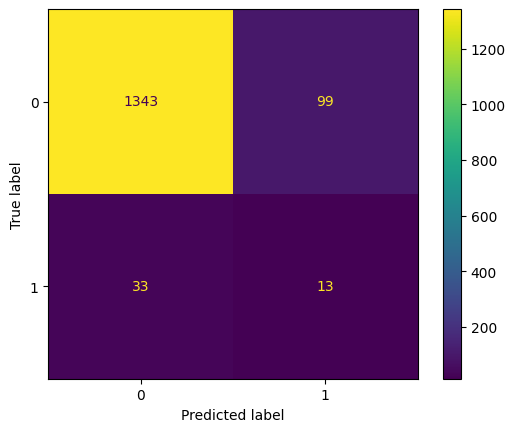

In [ ]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

plt.show()

Видно достаточно большое количество ложноположительных значений; для дальнейшего развития модели можно было бы попробовать вычленить дополнительные признаки из ряда (например, попробовать посмотреть на динамику изменения числа посетителей - можно ожидать, что к концу мероприятия посетители начнут расходится). Как бы то ни было, в качестве бейзлайна использовать полученную модель возможно


Теперь попробуем предсказать количество посетителей на test; в качестве метрики возьмем MAE, ибо в данных присутствуют пики (похожие даже на выбросы) и не стоит наказывать за них слишком сильно

In [ ]:
y_pred_test = trial.cnt_predict(periods=counters_test.shape[0], events=events_test)

print(f"MAE на test: {mean_absolute_error(counters_test['cnt'].values, y_pred_test):.4f}")

MAE на test: 16.6828


В целом, полученная метрика выглядит не очень большой (хотя бы не зашкаливающей); стоит взглянуть на графики прогноза и реальных значений

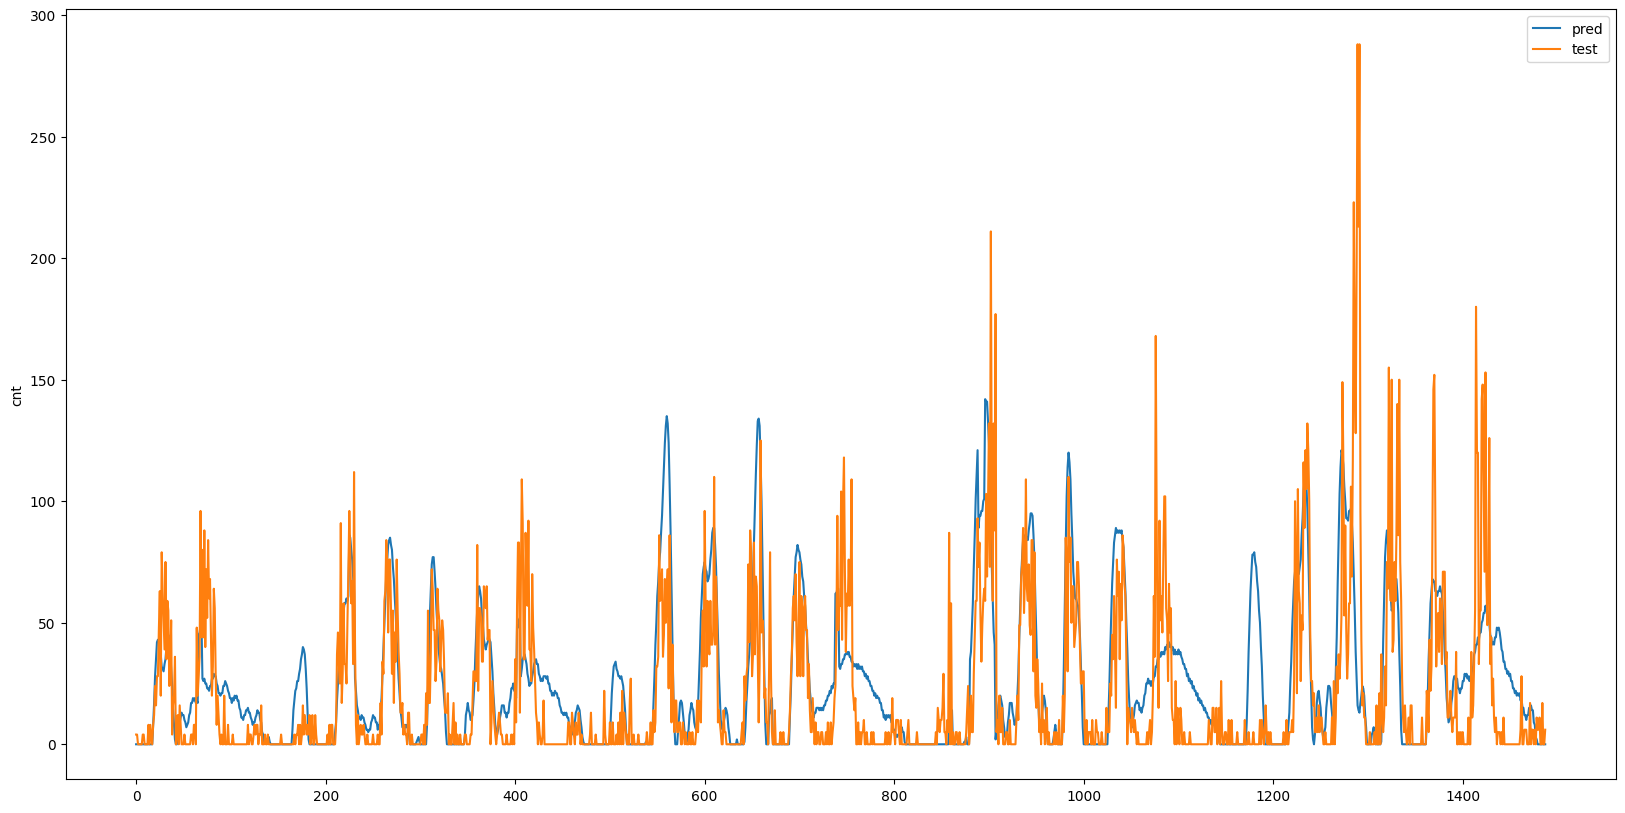

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(y_pred_test)
plt.plot(counters_test["cnt"].values)
plt.legend(["pred", "test"])
plt.ylabel("cnt")
plt.show()

По полученному графику виднно, что построения модель в целом улавливает характер изменения числа посетителей, хотя само изменение прогноза происходит слишком плавно (в силу специфики модели), в результате чего прогнозные значения просто не успевают за резко меняющимися значениями. Также местами происходит ложное срабатывание и ближе к концу прогнозного периода предсказания не улавливают приток посетителей во всей полноте. Опять же, в качестве некоторой отправной точки построенная модель может вполне сойти, однако для дальнейшего улучшения стоило бы попробовать построить более сложные модели прогнозирования
